In [1]:
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import shap
shap.initjs()

C:\Users\jlesl\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}
C:\Users\jlesl\Anaconda3\lib\site-packages\dask\dataframe\utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
C:\Users\jlesl\Anaconda3\lib\site-packages\distributed\config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


In [2]:
# read csv with specified date column, drop unnecessary columns
df = pd.read_csv(
    "./data/super_rugby_oddsportal.csv", parse_dates =["Date"]
).drop(
    ['Play-off Game?', 'Bookmakers Surveyed'], axis=1  # drop unnecessary columns
)

# ** is this necessary ?
spare = pd.read_csv("./data/super_rugby_oddsportal.csv").drop('Play-off Game?', axis=1).dropna()

# number of upcoming fixtures
n_matches = len(df[(df['Home Score']==0) & (df['Away Score']==0)])

df.head(n_matches)

,Date,Home Team,Away Team,Home Score,Away Score,Home Odds,Draw Odds,Away Odds
0,2020-03-06,Sunwolves,Brumbies,0,0,14.63,48.56,1.01
1,2020-03-06,Crusaders,Reds,0,0,1.04,42.71,10.76
2,2020-03-06,Waratahs,Chiefs,0,0,3.54,25.87,1.29
3,2020-03-07,Hurricanes,Blues,0,0,1.42,24.68,2.91
4,2020-03-07,Rebels,Lions,0,0,1.49,23.24,2.63
5,2020-03-07,Sharks,Jaguares,0,0,1.55,21.84,2.51
6,2020-03-07,Bulls,Highlanders,0,0,1.74,22.04,2.11


---
## 1. Feature engineering
### Numeric columns
  - `home_margin` = `home_score` - `away_score`: score differential w.r.t. home team
  - `home_win` = `home_score` > `away_score`: did the home team win (1/0)?
    - We will use this in the next block to create a moving window of home / away team win rates
  - `home_odds` = `home_score` - `away_score`: transformed bookmakers' odds into form pr(home team win)

In [3]:
# standardise naming format
df.columns = [x.lower().replace(' ', '_') for x in df.columns]

# extract year
df['year'] = df['date'].apply(lambda x: x.year)

# add home margin column
df['home_margin'] = df['home_score'] - df['away_score']
# add home win column
df['home_win'] = (df['home_score'] > df['away_score']).astype('int')

# aggregate odds into single probability variable
df['home_odds'] = df['away_odds'] / (df['home_odds'] + df['away_odds'])
df.drop(['draw_odds', 'away_odds'], axis=1, inplace=True)

df.head(15)

,date,home_team,away_team,home_score,away_score,home_odds,year,home_margin,home_win
0,2020-03-06,Sunwolves,Brumbies,0,0,0.064578,2020,0,0
1,2020-03-06,Crusaders,Reds,0,0,0.911864,2020,0,0
2,2020-03-06,Waratahs,Chiefs,0,0,0.267081,2020,0,0
3,2020-03-07,Hurricanes,Blues,0,0,0.672055,2020,0,0
4,2020-03-07,Rebels,Lions,0,0,0.638350,2020,0,0
5,2020-03-07,Sharks,Jaguares,0,0,0.618227,2020,0,0
6,2020-03-07,Bulls,Highlanders,0,0,0.548052,2020,0,0
7,2020-02-28,Highlanders,Rebels,22,28,0.815873,2020,-6,0
8,2020-02-28,Waratahs,Lions,29,17,0.605000,2020,12,1
9,2020-02-29,Hurricanes,Sunwolves,62,15,0.950271,2020,47,1


### Window functions
  - avg points scored by home side in last n games
  - avg points conceded by home side in last n games
  - avg points scored by away side in last n games
  - avg points conceded by away side in last n games

In [4]:
df = df.assign(
    # average odds for home_team in previous n home fixtures
    avg_hm_odd_5=df.groupby('home_team')['home_odds'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_hm_odd_10=df.groupby('home_team')['home_odds'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_hm_odd_20=df.groupby('home_team')['home_odds'].rolling(20).mean().shift(-20).reset_index(0, drop=True),
    # average odds for away team in previous n away fixtures
    avg_aw_odd_5= 1-df.groupby('away_team')['home_odds'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_aw_odd_10= 1-df.groupby('away_team')['home_odds'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_aw_odd_20= 1-df.groupby('away_team')['home_odds'].rolling(20).mean().shift(-20).reset_index(0, drop=True),
    # home team win rate previous n
    hm_wr_5=df.groupby('home_team')['home_win'].rolling(5).sum().shift(-5).reset_index(0, drop=True)/5,
    hm_wr_10=df.groupby('home_team')['home_win'].rolling(10).sum().shift(-10).reset_index(0, drop=True)/10,
    hm_wr_20=df.groupby('home_team')['home_win'].rolling(20).sum().shift(-20).reset_index(0, drop=True)/20,
    # away team win rate previous n
    aw_wr_5= 1-df.groupby('away_team')['home_win'].rolling(5).sum().shift(-5).reset_index(0, drop=True)/5,
    aw_wr_10= 1-df.groupby('away_team')['home_win'].rolling(10).sum().shift(-10).reset_index(0, drop=True)/10,
    aw_wr_20= 1-df.groupby('away_team')['home_win'].rolling(20).sum().shift(-20).reset_index(0, drop=True)/20,
    # average margin by home_team in previous n home fixtures
    avg_hm_marg_5=df.groupby('home_team')['home_margin'].rolling(5).mean().shift(-5).reset_index(0, drop=True),
    avg_hm_marg_10=df.groupby('home_team')['home_margin'].rolling(10).mean().shift(-10).reset_index(0, drop=True),
    avg_hm_marg_20=df.groupby('home_team')['home_margin'].rolling(20).mean().shift(-20).reset_index(0, drop=True)
)

df.drop(['date', 'home_score', 'away_score', 'home_win'], axis=1, inplace=True)

df = df.dropna().reset_index(drop=True)

df.head(n_matches)

,home_team,away_team,home_odds,year,home_margin,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20
0,Sunwolves,Brumbies,0.064578,2020,0,0.202183,0.243343,0.220530,0.402190,0.395699,0.361580,0.2,0.1,0.25,0.6,0.4,0.35,-27.4,-17.3,-12.55
1,Crusaders,Reds,0.911864,2020,0,0.809030,0.835835,0.821216,0.273540,0.271399,0.266292,1.0,0.9,0.95,0.0,0.2,0.15,16.4,20.8,20.75
2,Waratahs,Chiefs,0.267081,2020,0,0.577688,0.548024,0.567216,0.513306,0.445852,0.457903,0.2,0.4,0.50,0.6,0.7,0.60,-7.0,-2.0,4.10
3,Hurricanes,Blues,0.672055,2020,0,0.701329,0.675785,0.748131,0.478585,0.434480,0.432339,0.8,0.7,0.85,0.6,0.3,0.30,13.4,6.3,8.75
4,Rebels,Lions,0.638350,2020,0,0.554917,0.627721,0.553597,0.294272,0.426571,0.461474,0.2,0.5,0.45,0.0,0.3,0.35,-13.8,-4.5,-2.30
5,Sharks,Jaguares,0.618227,2020,0,0.640400,0.642325,0.618027,0.408362,0.338537,0.302508,0.4,0.4,0.55,0.6,0.6,0.50,-7.2,-1.9,1.75
6,Bulls,Highlanders,0.548052,2020,0,0.494520,0.593841,0.545479,0.317296,0.393885,0.476594,0.4,0.4,0.50,0.2,0.2,0.30,-4.2,-5.7,-0.40


### Categorical columns
  - home team / country
  - away team / country
  - year
  
Drop `country = Argentina` and `country = Japan` and all teams not currently in competition.
  
> **Test**: One-hot encoding vs label encoder

In [5]:
countries = {'Crusaders': 'NZ',
             'Chiefs': 'NZ',
             'Blues': 'NZ',
             'Hurricanes': 'NZ',
             'Highlanders': 'NZ',
             'Bulls': 'SA',
             'Cheetahs': 'SA',
             'Kings': 'SA',
             'Lions': 'SA',
             'Sharks': 'SA',
             'Stormers': 'SA',
             'Brumbies': 'AUS',
             'Force': 'AUS',
             'Rebels': 'AUS',
             'Reds': 'AUS',
             'Waratahs': 'AUS',
             'Jaguares': 'ARG',
             'Sunwolves': 'JPN'}

# add nationalities
df['home_country'] = df['home_team'].replace(countries)
df['away_country'] = df['away_team'].replace(countries)

# convert to pandas category dtypes
df[
    ['home_team', 'away_team', 'home_country', 'away_country']
] = df[
    ['home_team', 'away_team', 'home_country', 'away_country']
].astype('category')

# one-hot encode nationalities
df = pd.get_dummies(df, prefix='home_country', columns=['home_country'])
df = pd.get_dummies(df, prefix='away_country', columns=['away_country'])
    
# one-hot encode team names
df = pd.get_dummies(df, prefix='home_team', columns=['home_team'])
df = pd.get_dummies(df, prefix='away_team', columns=['away_team'])

# drop irrelevent columns
df.drop(['home_country_ARG', 'home_country_JPN', 'away_country_ARG', 'away_country_JPN',
         'home_team_Cheetahs', 'away_team_Cheetahs', 'home_team_Kings', 
         'away_team_Kings', 'home_team_Force', 'away_team_Force'], 
        axis=1,
        inplace=True)

df.head(n_matches)

,home_odds,year,home_margin,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20,home_country_AUS,home_country_NZ,home_country_SA,away_country_AUS,away_country_NZ,away_country_SA,home_team_Blues,home_team_Brumbies,home_team_Bulls,home_team_Chiefs,home_team_Crusaders,home_team_Highlanders,home_team_Hurricanes,home_team_Jaguares,home_team_Lions,home_team_Rebels,home_team_Reds,home_team_Sharks,home_team_Stormers,home_team_Sunwolves,home_team_Waratahs,away_team_Blues,away_team_Brumbies,away_team_Bulls,away_team_Chiefs,away_team_Crusaders,away_team_Highlanders,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs
0,0.064578,2020,0,0.202183,0.243343,0.220530,0.402190,0.395699,0.361580,0.2,0.1,0.25,0.6,0.4,0.35,-27.4,-17.3,-12.55,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.911864,2020,0,0.809030,0.835835,0.821216,0.273540,0.271399,0.266292,1.0,0.9,0.95,0.0,0.2,0.15,16.4,20.8,20.75,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
2,0.267081,2020,0,0.577688,0.548024,0.567216,0.513306,0.445852,0.457903,0.2,0.4,0.50,0.6,0.7,0.60,-7.0,-2.0,4.10,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0.672055,2020,0,0.701329,0.675785,0.748131,0.478585,0.434480,0.432339,0.8,0.7,0.85,0.6,0.3,0.30,13.4,6.3,8.75,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.638350,2020,0,0.554917,0.627721,0.553597,0.294272,0.426571,0.461474,0.2,0.5,0.45,0.0,0.3,0.35,-13.8,-4.5,-2.30,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
5,0.618227,2020,0,0.640400,0.642325,0.618027,0.408362,0.338537,0.302508,0.4,0.4,0.55,0.6,0.6,0.50,-7.2,-1.9,1.75,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6,0.548052,2020,0,0.494520,0.593841,0.545479,0.317296,0.393885,0.476594,0.4,0.4,0.50,0.2,0.2,0.30,-4.2,-5.7,-0.40,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


---

In [6]:
X = df[n_matches:].drop(['home_margin'], axis=1)
y = df[n_matches:].home_margin.values

In [7]:
# upcoming week's fixtures
X_temp = df[:n_matches].drop(['home_margin'], axis=1)
y_temp = df[:n_matches].home_margin.values

In [8]:
y.shape

(956,)

In [9]:
X.shape

(956, 53)

---
## 2. Train model
  - To do: train neural network using embeddings for teams instead of one-hot encoding

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.1, shuffle=False)

In [11]:
X_train.head()

,home_odds,year,avg_hm_odd_5,avg_hm_odd_10,avg_hm_odd_20,avg_aw_odd_5,avg_aw_odd_10,avg_aw_odd_20,hm_wr_5,hm_wr_10,hm_wr_20,aw_wr_5,aw_wr_10,aw_wr_20,avg_hm_marg_5,avg_hm_marg_10,avg_hm_marg_20,home_country_AUS,home_country_NZ,home_country_SA,away_country_AUS,away_country_NZ,away_country_SA,home_team_Blues,home_team_Brumbies,home_team_Bulls,home_team_Chiefs,home_team_Crusaders,home_team_Highlanders,home_team_Hurricanes,home_team_Jaguares,home_team_Lions,home_team_Rebels,home_team_Reds,home_team_Sharks,home_team_Stormers,home_team_Sunwolves,home_team_Waratahs,away_team_Blues,away_team_Brumbies,away_team_Bulls,away_team_Chiefs,away_team_Crusaders,away_team_Highlanders,away_team_Hurricanes,away_team_Jaguares,away_team_Lions,away_team_Rebels,away_team_Reds,away_team_Sharks,away_team_Stormers,away_team_Sunwolves,away_team_Waratahs
7,0.815873,2020,0.778534,0.717402,0.742375,0.436625,0.446724,0.405218,0.4,0.5,0.75,0.2,0.3,0.35,4.0,1.7,10.55,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
8,0.605000,2020,0.554860,0.559793,0.570414,0.283347,0.440957,0.480460,0.2,0.4,0.50,0.2,0.4,0.40,-8.8,-2.1,3.85,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
9,0.950271,2020,0.666991,0.664820,0.734027,0.160066,0.154683,0.119239,0.8,0.7,0.85,0.0,0.3,0.15,6.0,2.2,7.25,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
10,0.518325,2020,0.582545,0.510963,0.429725,0.401215,0.344092,0.353326,0.6,0.6,0.60,0.6,0.6,0.40,9.4,6.5,3.60,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
11,0.731959,2020,0.695486,0.618988,0.584283,0.461002,0.455718,0.444328,0.8,0.7,0.70,0.4,0.2,0.25,12.0,9.8,7.75,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### Evaluate performance

In [12]:
model = XGBRegressor(max_depth=1, learning_rate=.1, n_estimators=100, n_jobs=-1, min_child_weight=5, subsample=.45, random_state=0)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.45, tree_method=None,
             validate_parameters=False, verbosity=None)

In [13]:
# training data
print(f'Train RMSE: {np.sqrt(mean_squared_error(model.predict(X_train), y_train)):.3f}')
print(f'Train MAE: {mean_absolute_error(y_train, model.predict(X_train)):.3f}')

Train RMSE: 13.936
Train MAE: 10.823


In [14]:
# test data
print(f'Test RMSE: {np.sqrt(mean_squared_error(model.predict(X_test), y_test)):.3f}')
print(f'Test MAE: {mean_absolute_error(y_test, model.predict(X_test)):.3f}')

Test RMSE: 11.800
Test MAE: 9.061


### Train on all data (if not overfitting)

In [15]:
# include feature standardizer for numeric columns

# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# # standardize first two columns
# ct = ColumnTransformer(
#     [('scaler', StandardScaler(), [0, 1, -1])]
# )

# xgb = XGBRegressor(max_depth=1, learning_rate=.1, n_estimators=100, n_jobs=-1, min_child_weight=5, subsample=.45, random_state=0)

# model = Pipeline(
#     [
#         ('transformer', ct),
#         ('regressor', xgb)        
#     ]
# )

In [16]:
model.fit(X, y)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.1, max_delta_step=0, max_depth=1,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=-1, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.45, tree_method=None,
             validate_parameters=False, verbosity=None)

In [17]:
model.fit(X, y)

print(f'RMSE: {np.sqrt(mean_squared_error(model.predict(X), y)):.3f}')
print(f'MAE: {mean_absolute_error(y, model.predict(X)):.3f}')

RMSE: 13.746
MAE: 10.643


### SHAP values
[Here is a nice notebook tutorial](https://slundberg.github.io/shap/notebooks/Census%20income%20classification%20with%20XGBoost.html)  for working with SHAP values.

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


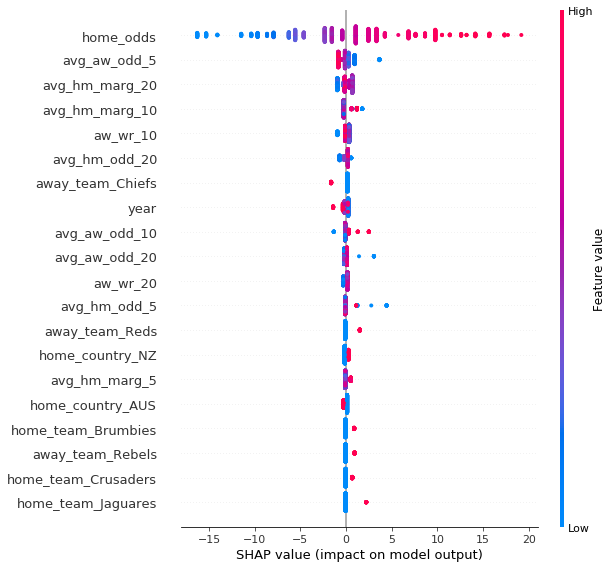

In [18]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)
shap.summary_plot(shap_values, X)

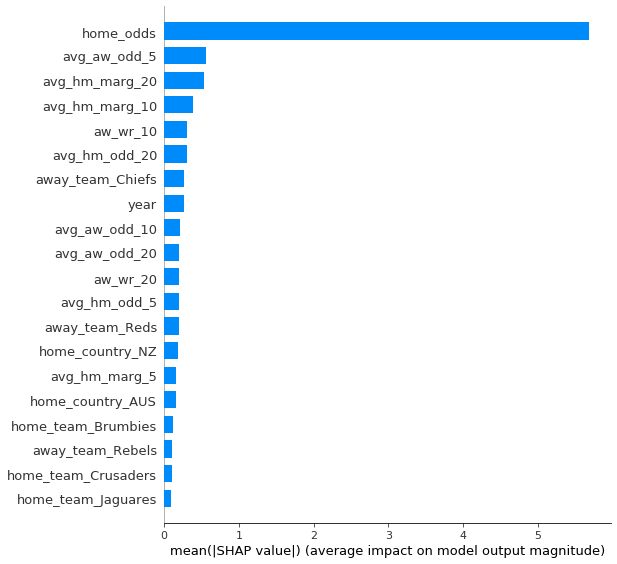

In [19]:
shap.summary_plot(shap_values, X, plot_type="bar")

In [20]:
shap.force_plot(explainer.expected_value, shap_values[:1000,:], X.iloc[:1000,:])

## 3. Make predictions for upcoming week

In [21]:
# predict for upcoming week
np.vstack((model.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

array([[-9.567160606384277, 'Sunwolves', 'Brumbies'],
       [26.703845977783203, 'Crusaders', 'Reds'],
       [-10.073148727416992, 'Waratahs', 'Chiefs'],
       [4.421782970428467, 'Hurricanes', 'Blues'],
       [2.7555019855499268, 'Rebels', 'Lions'],
       [1.7822240591049194, 'Sharks', 'Jaguares'],
       [-0.6978517770767212, 'Bulls', 'Highlanders']], dtype=object)

In [22]:
temp = np.vstack((model.predict(X_temp), spare['Home Team'][:n_matches], spare['Away Team'][:n_matches])).T

In [23]:
preds_df = pd.DataFrame(temp, columns=["Home_Margin", "Home_Team", "Away_Team"])

In [24]:
preds_df["Home_Margin"] = preds_df.Home_Margin.apply(lambda x: int(np.round(x, 0)))
preds_df

,Home_Margin,Home_Team,Away_Team
0,-10,Sunwolves,Brumbies
1,27,Crusaders,Reds
2,-10,Waratahs,Chiefs
3,4,Hurricanes,Blues
4,3,Rebels,Lions
5,2,Sharks,Jaguares
6,-1,Bulls,Highlanders


### Explain single prediction

In [25]:
MATCH_NO = 6

print(f'Explaining result of  {preds_df.iloc[MATCH_NO,1]} vs {preds_df.iloc[MATCH_NO,2]}:\n')
shap_values = explainer.shap_values(X_temp)
shap.force_plot(explainer.expected_value, shap_values[MATCH_NO,:], X_temp.iloc[MATCH_NO,:])

Explaining result of  Bulls vs Highlanders:

